In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

os.environ["KERAS_BACKEND"] = "torch"
import keras

In [2]:
keras.utils.set_random_seed(15151515)

In [3]:
df_train = pd.read_csv('data/tr80.csv')
df_test = pd.read_csv('data/tt20.csv')

In [4]:
df_train.describe()

,Unnamed: 0,ID,CLASS,B7_1,B7_2,B7_3,B7_4,B7_5,B7_6,B7_7,...,B4_3,B4_4,B4_5,B4_6,B4_7,B4_8,B4_9,B4_10,B4_11,B4_12
count,12140.000000,12140.000000,12140.000000,7363.000000,4313.000000,11898.000000,11906.000000,11907.000000,12109.000000,12134.000000,...,11898.000000,11906.000000,11907.000000,12109.000000,12134.000000,12130.000000,12137.000000,11813.000000,11445.000000,4055.000000
mean,6069.500000,7619.770181,8.340857,1608.827889,1720.006086,1510.175408,1845.876953,2613.479634,3405.248679,3432.516565,...,904.410846,943.534499,879.852440,866.655752,936.175972,947.397918,1005.228640,987.131508,920.339428,1087.467263
std,3504.660469,4445.453009,5.599224,1235.039249,1249.205711,776.402814,858.231710,1202.509465,1232.234781,1413.421517,...,519.929347,523.610878,556.097036,546.556647,636.263642,573.896767,534.294807,547.096558,681.492656,1299.846852
min,0.000000,2.000000,1.000000,1.000000,1.000000,13.000000,28.000000,88.000000,84.000000,99.000000,...,31.000000,79.000000,80.000000,111.000000,91.000000,55.000000,72.000000,1.000000,1.000000,1.000000
25%,3034.750000,3780.750000,3.000000,868.500000,1073.500000,949.125000,1200.000000,1648.500000,2603.000000,2421.000000,...,595.000000,636.000000,500.750000,529.000000,469.000000,554.125000,688.500000,659.000000,530.000000,406.500000
50%,6069.500000,7596.500000,7.000000,1327.000000,1469.000000,1424.500000,1774.000000,2536.500000,3433.000000,3260.000000,...,819.500000,837.250000,785.000000,746.000000,740.000000,856.000000,926.500000,896.000000,766.500000,717.000000
75%,9104.250000,11439.250000,11.000000,1936.500000,1965.500000,1956.000000,2388.750000,3444.000000,4235.000000,4483.000000,...,1079.375000,1116.000000,1094.000000,1054.000000,1258.000000,1216.000000,1209.000000,1188.000000,1111.000000,1237.000000
max,12139.000000,30219.000000,40.000000,13860.000000,11126.000000,6794.000000,9689.000000,7901.000000,7689.000000,11556.000000,...,7100.000000,9752.000000,6280.000000,9896.000000,6088.000000,6484.000000,6456.000000,15808.000000,10416.000000,11632.000000


In [5]:
bands = set()
dates = set()
for column in df_train.columns:
    if not column.startswith("B"):
        continue

    parts = column.split('_')
    if len(parts) != 2:
        continue

    if parts[0] not in bands:
        bands.add(parts[0])

    if parts[1] not in dates:
        dates.add(int(parts[1]))

bands = list(bands)
dates = list(dates)

bands.sort()
dates.sort()
dates = dates[3:-3]

drop_dates = [1, 2, 3, 10, 11, 12]

for date in drop_dates:
    for band in bands:
        df_train = df_train.drop(columns=[f"{band}_{date}"])
        df_test = df_test.drop(columns=[f"{band}_{date}"])

df_train = df_train.dropna()
df_test = df_test.dropna()

for band in bands:
    for date in dates:
        df_train[f"{band}_{date}"] = df_train[f"{band}_{date}"].fillna(20000) / 5000
        df_test[f"{band}_{date}"] = df_test[f"{band}_{date}"].fillna(20000) / 5000

df_train = df_train[df_train.groupby("CLASS")["CLASS"].transform('count').ge(20)]
df_test = df_test[df_test.groupby("CLASS")["CLASS"].transform('count').ge(20)]

In [6]:
print(f"Bands count: {len(bands)}")
print(bands)

print(f"Dates count: {len(dates)}")
print(dates)

Bands count: 12
['B1', 'B11', 'B12', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9']
Dates count: 6
[4, 5, 6, 7, 8, 9]


In [7]:
train_classes = df_train["CLASS"].unique()
train_classes.sort()

print(len(train_classes))
print(train_classes)

21
[ 1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 21 26 34]


In [8]:
from feature_optimization import FeatureOptimizer
import feature_opt_functions as funcs
from indices import *

In [9]:
def get_OneVsOthers(df, class_N):
    one = df.loc[df["CLASS"] == class_N]
    others = df.loc[df["CLASS"] != class_N]
    return one, others

def get_Data(date, one, zero):
    BANDS = bands

    data_one = np.empty((len(bands), len(one)))
    data_zero = np.empty((len(bands), len(zero)))
    data = [data_zero, data_one]

    for i in range(len(BANDS)):
        data_one[i, :] = one[f"{BANDS[i]}_{date}"]
        data_zero[i, :] = zero[f"{BANDS[i]}_{date}"]

    return data

In [10]:
encoder = IndicesClassEncoderEq([Hue], list(range(len(bands))))
print(encoder.total_length)

args = { 
    "num_generations":100, 
    "num_parents_mating":2,
    "parent_selection_type":"sss",
    "keep_elitism":1,
    "sol_per_pop":100,
    "mutation_probability":0.15,
    "parallel_processing":8
}

total_features = set()
for name in train_classes:
    one, zero = get_OneVsOthers(df_train, name)

    best_features = None
    fitness = -100
    for date in dates:
        opt = FeatureOptimizer(encoder, 1,
                        funcs.bhattacharyya_distance, 
                        funcs.spearman_independency, 
                        optimization_method="genetic",
                        optimizer_args=args,
                        informativeness_threshold=0.0, 
                        independency_threshold=0.0,
                        set_independency="geometric_mean")
        
        data = get_Data(date, one, zero)

        print(f"'{name} ({len(one)})' vs 'all ({len(zero)})' at {date}:")
        opt.fit(data, data[1], True)

        new_fitness = opt.get_fitness_()
        if new_fitness > fitness:
            fitness = new_fitness
            best_features = opt.selected_features

        print(f"Selected features: {opt.selected_features}")
        print(f"-----------------------------------------")

    if not (best_features is None) and len(best_features) > 0:
        for feature in best_features:
            if not feature in total_features:
                total_features.add(feature)

1728
'1 (415)' vs 'all (11142)' at 4:
Fitness (Gen 17): 0.3393129065043452

e:\STUDY\deep-learning-2024\.venv\Lib\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


Fitness (Gen 100): 0.3393129065043452
Selected features: [207]
-----------------------------------------
'1 (415)' vs 'all (11142)' at 5:
Fitness (Gen 100): 0.5718546531200983
Selected features: [986]
-----------------------------------------
'1 (415)' vs 'all (11142)' at 6:
Fitness (Gen 100): 0.9429522747908947
Selected features: [1347]
-----------------------------------------
'1 (415)' vs 'all (11142)' at 7:
Fitness (Gen 100): 0.9065555540857452
Selected features: [1342]
-----------------------------------------
'1 (415)' vs 'all (11142)' at 8:
Fitness (Gen 100): 0.6848326035906608
Selected features: [555]
-----------------------------------------
'1 (415)' vs 'all (11142)' at 9:
Fitness (Gen 100): 0.5294974673180957
Selected features: [1527]
-----------------------------------------
'2 (2194)' vs 'all (9363)' at 4:
Fitness (Gen 100): 0.21426465920226356
Selected features: [1205]
-----------------------------------------
'2 (2194)' vs 'all (9363)' at 5:
Fitness (Gen 100): 0.40988619

In [11]:
total_features = list(total_features)
print("Total:", len(total_features))

Total: 21


In [12]:
def get_BigData(df, total_features):
    bigdata = np.empty((len(dates), len(total_features), len(df)))

    for date_i in range(len(dates)):
        data = np.empty((len(bands), len(df)))

        BANDS = bands
        for i in range(len(BANDS)):
            data[i, :] = df[f"{BANDS[i]}_{dates[date_i]}"]

        for feature_i in range(len(total_features)):
            bigdata[date_i, feature_i, :] = encoder.getIndex(total_features[feature_i]).getValue(data)

    return bigdata.swapaxes(1, 2).swapaxes(0, 1)

In [13]:
mapper = [None]*41
for i in range(len(train_classes)):
    mapper[train_classes[i]] = i

In [14]:
def pd_2_mts_XY(df):
    X = np.empty((df.shape[0], len(dates), len(bands)))
    Y = np.zeros((df.shape[0], len(train_classes)))

    counter = 0
    for _, row in df.iterrows():
        for date_i in range(len(dates)):
            for band_i in range(len(bands)):
                X[counter, date_i, band_i] = row[f"{bands[band_i]}_{dates[date_i]}"]
        
        Y[counter, mapper[int(row["CLASS"])]] = 1
        counter += 1

    return X, Y


In [15]:
train_X = get_BigData(df_train, total_features)
test_X = get_BigData(df_test, total_features)

_, train_Y = pd_2_mts_XY(df_train)
_, test_Y = pd_2_mts_XY(df_test)

In [16]:
print(train_X.shape)

(11557, 6, 21)


In [17]:
model = keras.Sequential(
    [
        keras.layers.Input(shape=(len(dates), train_X.shape[2])),
        keras.layers.Dropout(0.2),
        keras.layers.GRU(64, return_sequences=True),
        keras.layers.GRU(32),
        keras.layers.Dense(len(train_classes), activation="softmax")
    ]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout (Dropout)               │ (None, 6, 21)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 6, 64)          │        16,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 21)             │           693 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,805 (104.71 KB)

 Trainable params: 26,805 (104.71 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
print(train_X.min())
print(train_X.max())

-1.3409480482617036
1.3127062597874848


In [19]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["categorical_accuracy", "f1_score", "precision", "recall"],
)

In [20]:
history = model.fit(
    train_X,
    train_Y,
    batch_size=128,
    epochs=50,
    verbose=1,
    validation_data=(test_X, test_Y)
)

Epoch 1/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - categorical_accuracy: 0.2169 - f1_score: 0.0484 - loss: 2.6515 - precision: 0.2349 - recall: 0.0064 - val_categorical_accuracy: 0.5379 - val_f1_score: 0.1485 - val_loss: 1.6401 - val_precision: 0.7504 - val_recall: 0.1683
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - categorical_accuracy: 0.5210 - f1_score: 0.1593 - loss: 1.5994 - precision: 0.7319 - recall: 0.2362 - val_categorical_accuracy: 0.6465 - val_f1_score: 0.2713 - val_loss: 1.0928 - val_precision: 0.7809 - val_recall: 0.4696
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - categorical_accuracy: 0.6195 - f1_score: 0.2900 - loss: 1.1843 - precision: 0.7446 - recall: 0.4543 - val_categorical_accuracy: 0.7279 - val_f1_score: 0.3790 - val_loss: 0.8916 - val_precision: 0.7995 - val_recall: 0.5984
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - categorical_accuracy: 0.6787 - f1_score: 0.3572 - loss: 1.0214 - precision: 0.7701 - recall: 0.5691 - val_categorical_accu

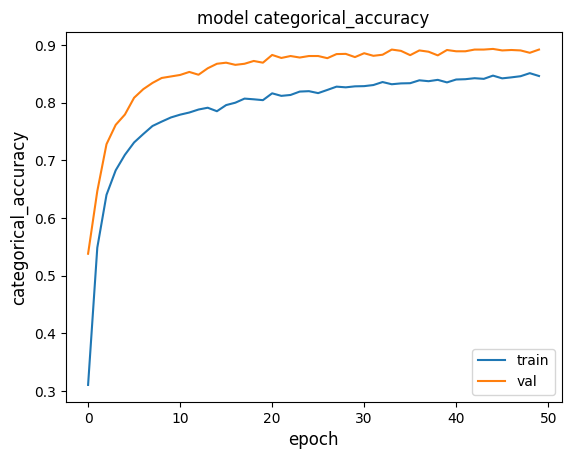

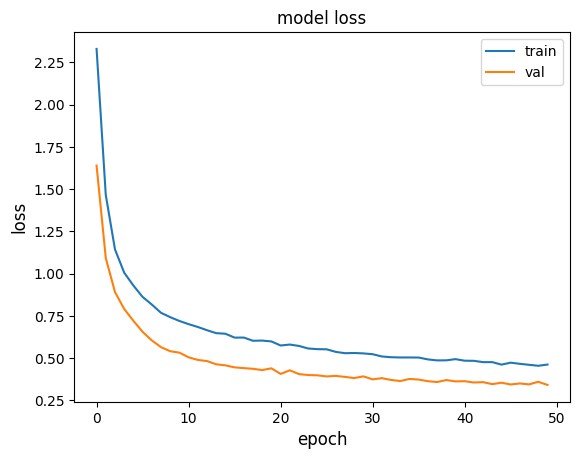

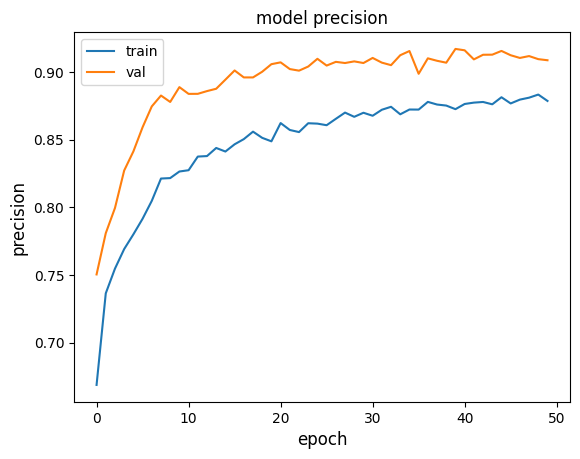

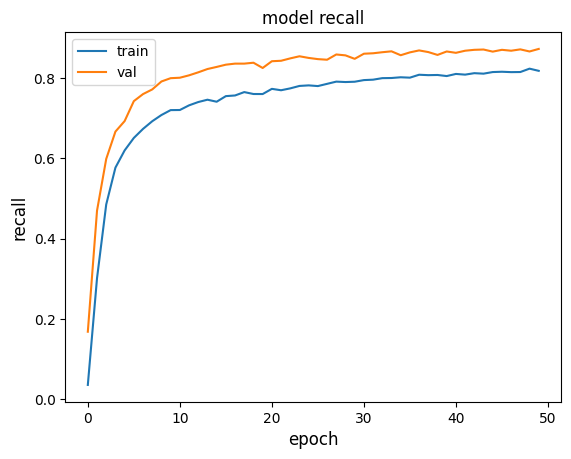

In [21]:
metrics = ["categorical_accuracy", "loss", "precision", "recall"]

for metric in metrics:
    plt.figure()
    plt.plot(history.history[metric])
    plt.plot(history.history["val_" + metric])
    plt.title("model " + metric)
    plt.ylabel(metric, fontsize="large")
    plt.xlabel("epoch", fontsize="large")
    plt.legend(["train", "val"], loc="best")
    plt.show()
    plt.close()

In [22]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [23]:
pred_train = np.argmax(model.predict(train_X), axis=1)
pred_test = np.argmax(model.predict(test_X), axis=1)

  1/362 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step

362/362 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


In [24]:
print(classification_report(np.argmax(train_Y, axis=1), pred_train))

              precision    recall  f1-score   support

           0       0.83      0.66      0.74       415
           1       0.89      0.93      0.91      2194
           2       0.96      0.96      0.96       382
           3       0.59      0.51      0.55        63
           4       0.97      0.97      0.97      1388
           5       0.86      0.81      0.83        62
           6       0.88      0.98      0.93      1544
           7       0.95      0.78      0.86       631
           8       0.95      0.98      0.97       632
           9       0.82      0.95      0.88      1624
          10       0.94      0.79      0.86       188
          11       0.82      0.98      0.89       568
          12       0.90      0.82      0.86       279
          13       0.75      0.65      0.70       685
          14       0.81      0.61      0.70       107
          15       0.69      0.22      0.34        81
          16       0.71      0.32      0.44       276
          17       0.85    

e:\STUDY\deep-learning-2024\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\STUDY\deep-learning-2024\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\STUDY\deep-learning-2024\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [25]:
print(classification_report(np.argmax(test_Y, axis=1), pred_test))

              precision    recall  f1-score   support

           0       0.84      0.69      0.75        96
           1       0.91      0.93      0.92       544
           2       0.96      0.89      0.92        88
           3       0.00      0.00      0.00         0
           4       0.97      0.95      0.96       340
           5       0.00      0.00      0.00         0
           6       0.91      0.98      0.94       380
           7       0.93      0.79      0.86       150
           8       0.95      0.99      0.97       146
           9       0.85      0.96      0.90       394
          10       0.94      0.80      0.86        40
          11       0.83      0.96      0.89       136
          12       0.86      0.82      0.84        60
          13       0.80      0.68      0.73       160
          14       0.00      0.00      0.00         0
          16       0.78      0.25      0.37        57
          17       0.82      0.96      0.88        67
          18       0.33    

e:\STUDY\deep-learning-2024\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\STUDY\deep-learning-2024\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\STUDY\deep-learning-2024\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


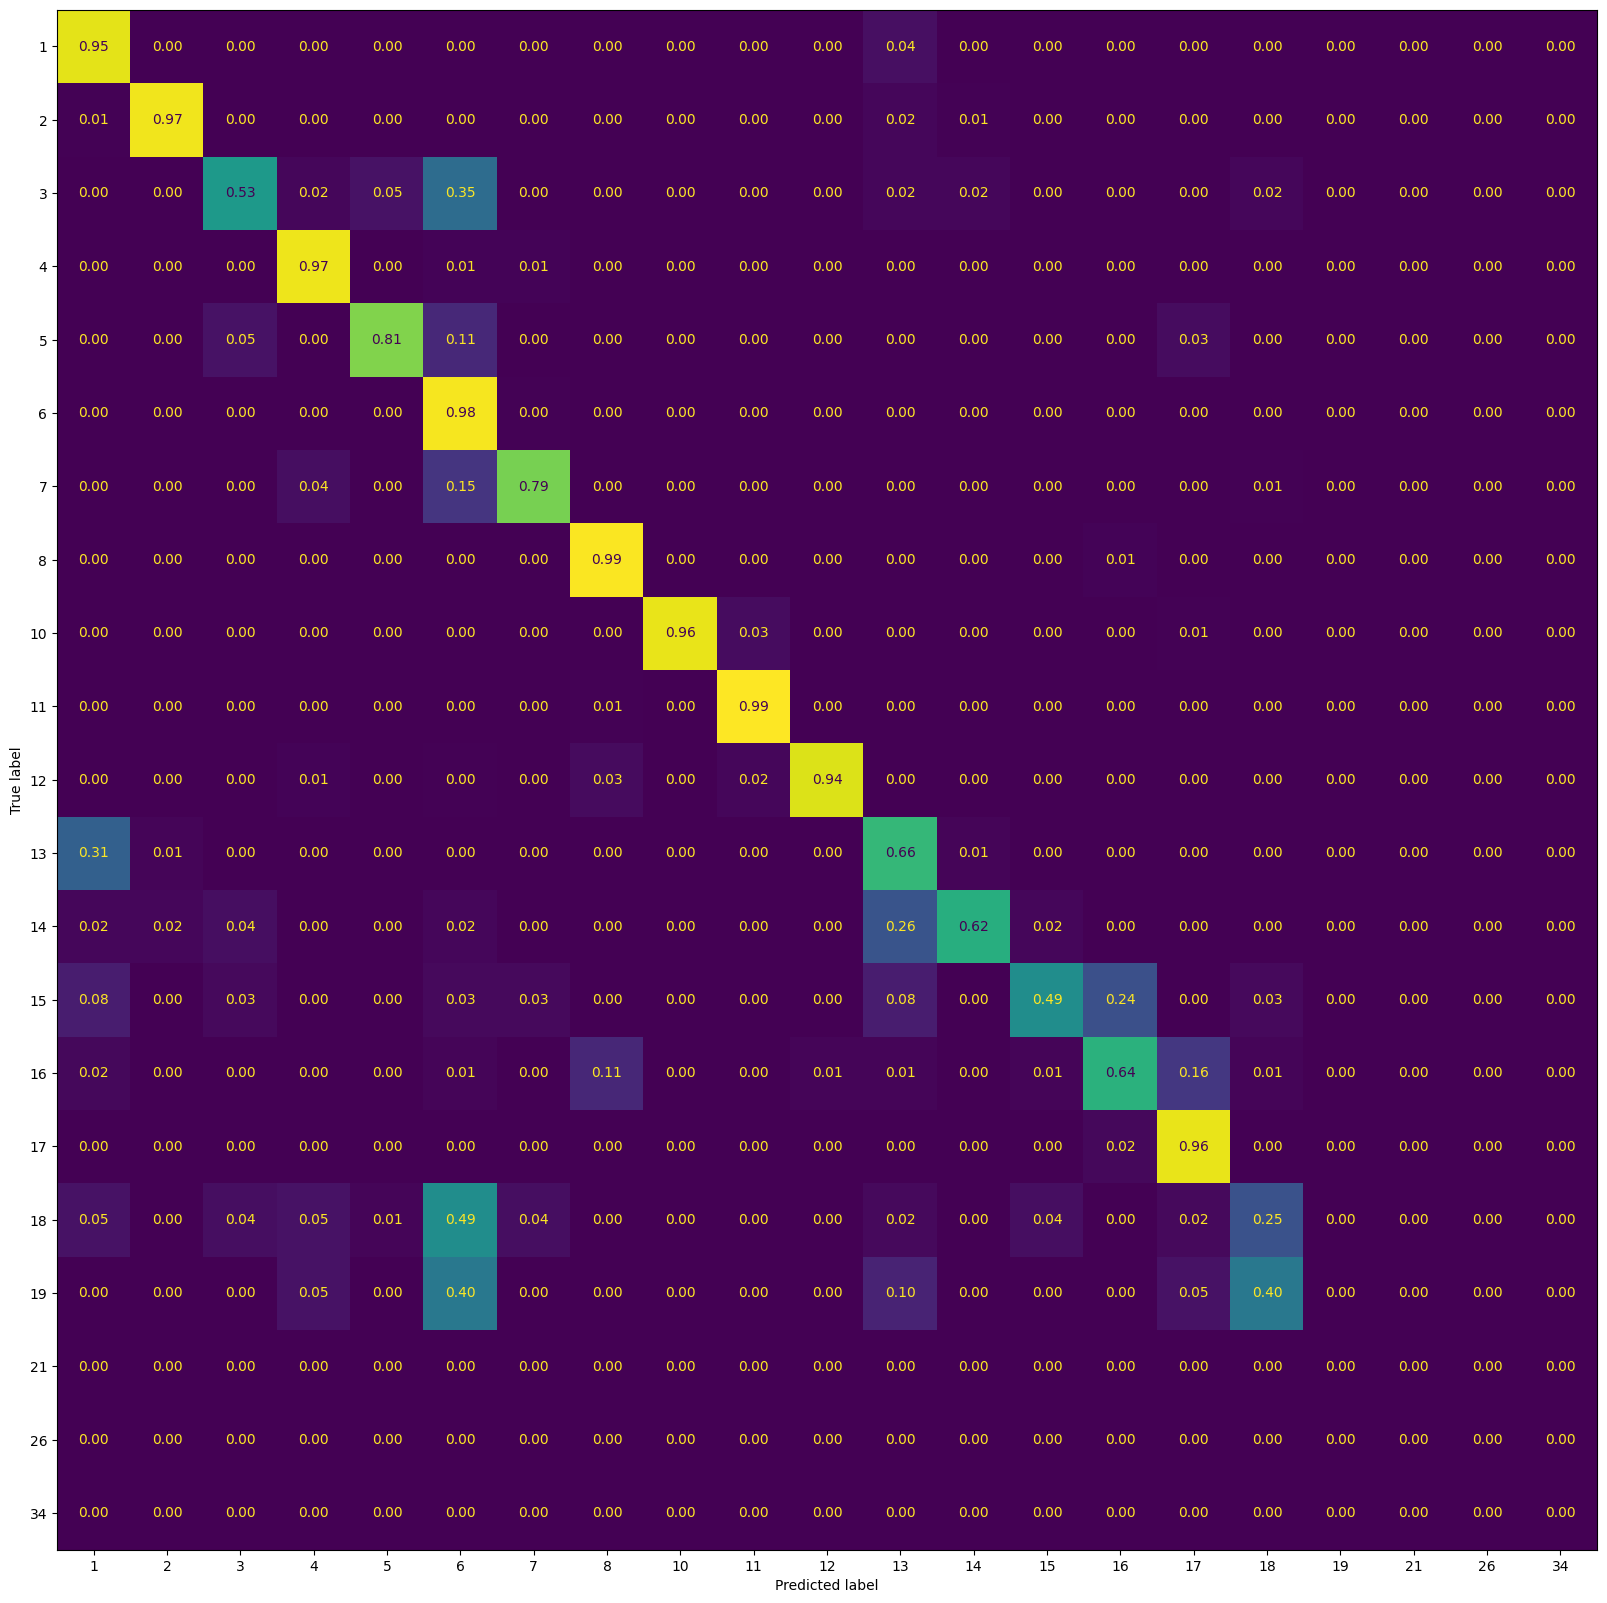

In [26]:
fig, ax = plt.subplots(figsize=(20,20))
ConfusionMatrixDisplay.from_predictions(np.argmax(train_Y, axis=1), pred_train, normalize='true', labels=train_classes, display_labels=train_classes, values_format=".2f", ax=ax, colorbar=False)

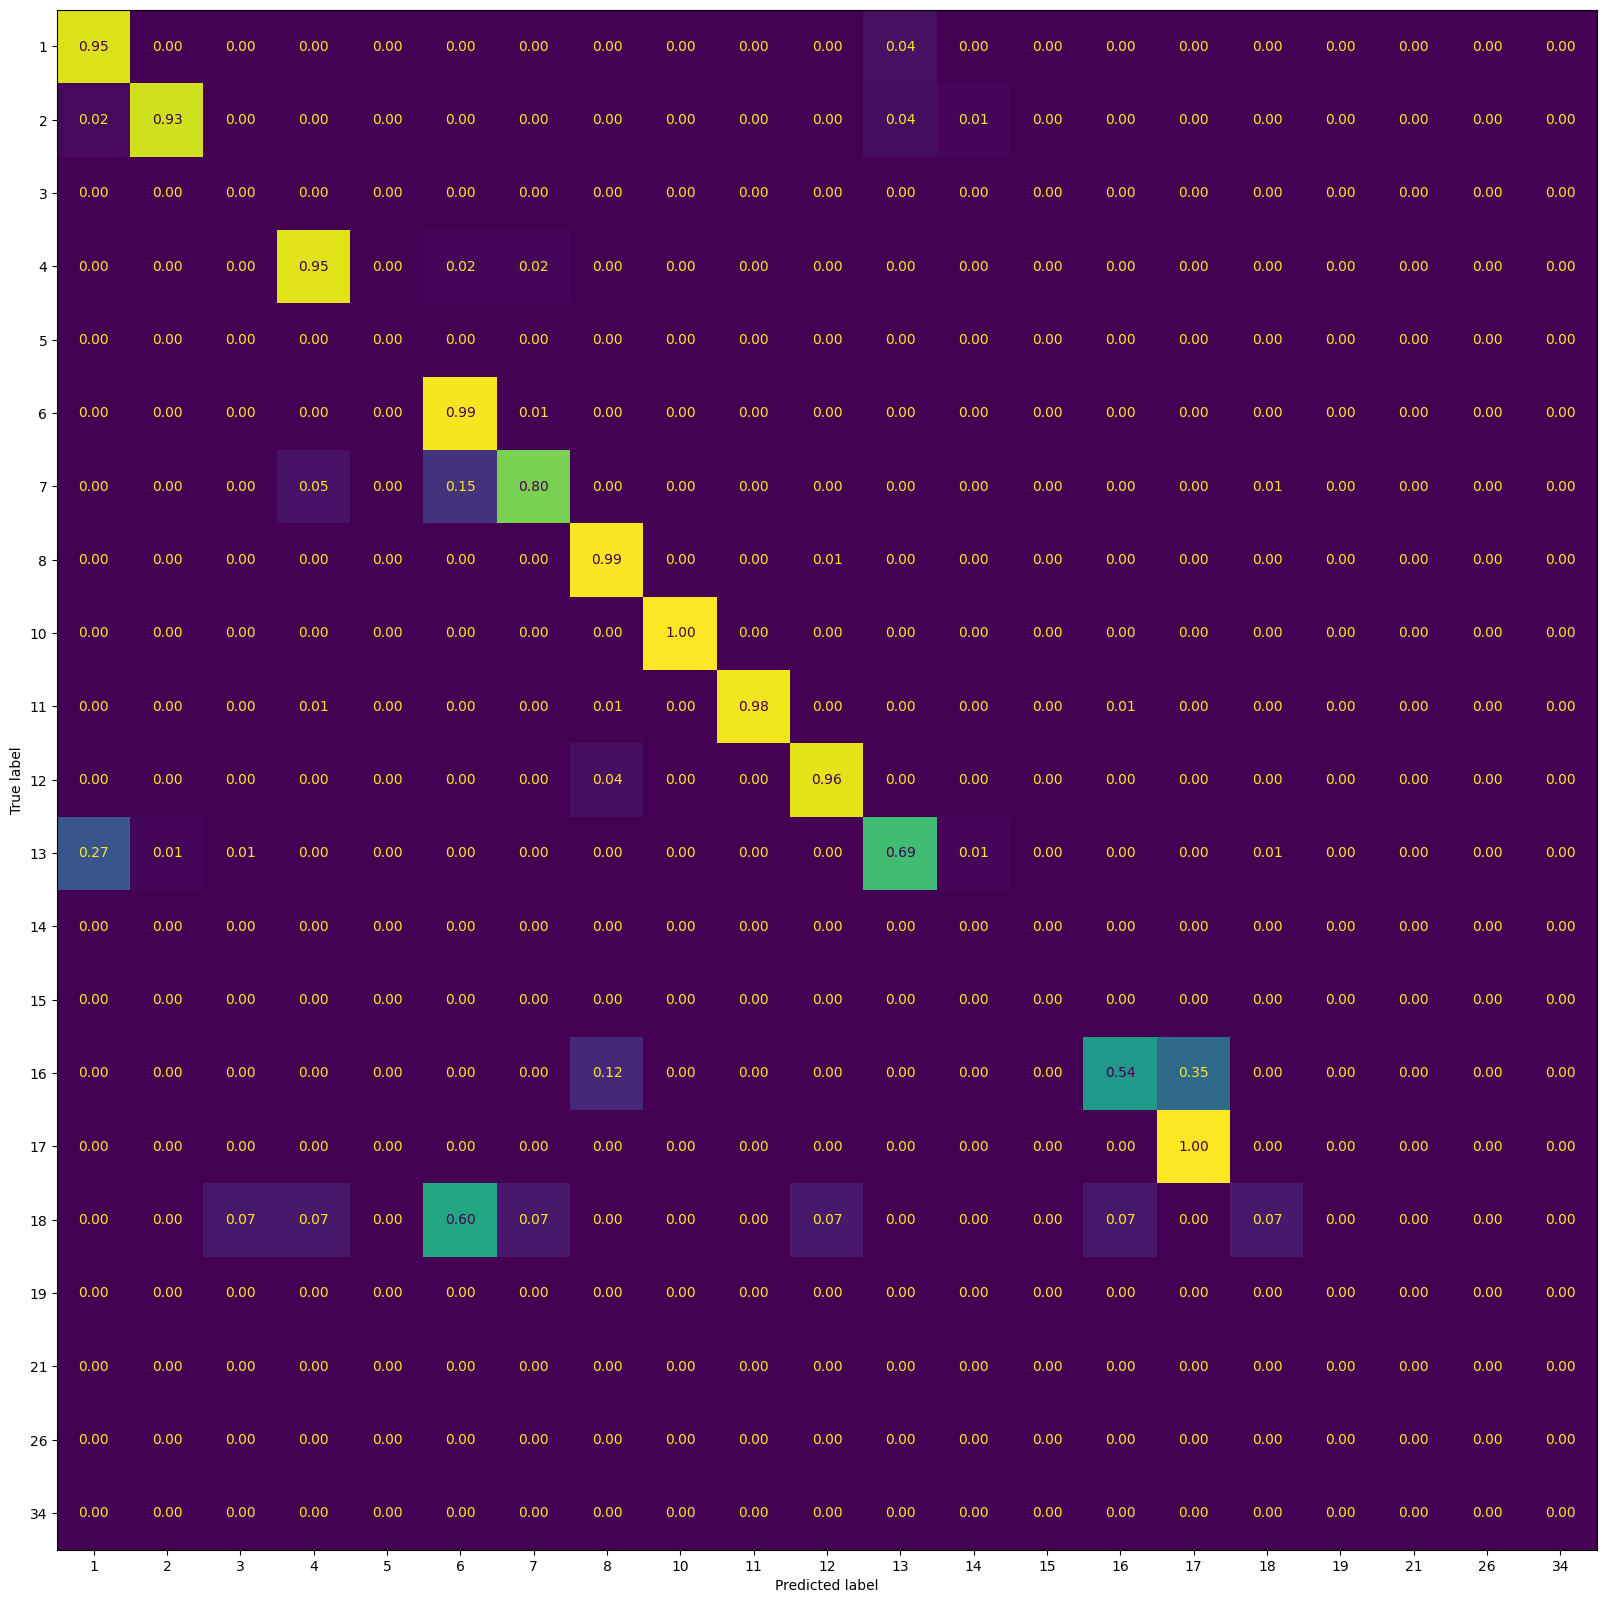

In [27]:
fig, ax = plt.subplots(figsize=(20,20))
ConfusionMatrixDisplay.from_predictions(np.argmax(test_Y, axis=1), pred_test, normalize='true', labels=train_classes, display_labels=train_classes, values_format=".2f", ax=ax, colorbar=False)